In [ ]:
import torch

from bliss.encoders.autoencoder import OneCenteredGalaxyAE

import numpy as np

import matplotlib.pyplot as plt

import sep

from bliss.datasets.lsst import get_default_lsst_psf

In [ ]:
device = torch.device("cuda:0")

In [ ]:
ae = OneCenteredGalaxyAE()
ae.load_state_dict(torch.load("../models/autoencoder.pt"))

/tmp/ipykernel_1812576/2954446164.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load("../models/autoencoder.pt"))


<All keys matched successfully>

In [ ]:
val_ds = torch.load("../data/datasets/val_ae_ds_42_1.pt")

/tmp/ipykernel_1812576/3420070014.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_ds = torch.load("../data/datasets/val_ae_ds_42_1.pt")


In [ ]:
images = val_ds['images'].float()
noiseless = val_ds['noiseless'].float()
background = val_ds['background'].float()
galaxy_params = val_ds['galaxy_params'].float()

images.shape, background.shape, galaxy_params.shape

(torch.Size([81864, 1, 53, 53]),
 torch.Size([81864, 1, 53, 53]),
 torch.Size([81864, 11]))

In [ ]:
psf = get_default_lsst_psf()
psf_fwhm = psf.calculateFWHM()
psf_fwhm

0.8003397403887131

In [ ]:
ab = galaxy_params[:, 3]
ad = galaxy_params[:, 4]
bb = galaxy_params[:, 5]
bd = galaxy_params[:, 6]
pab = galaxy_params[:, 7]
pad = galaxy_params[:, 8]
# fnb, fnd, fnagn, ab, ad, bb, bd, pab, pad, _, total_flux = galaxy_params.numpy()  # noqa:WPS236


a_comb = torch.concatenate([ad.reshape(1, -1), ab.reshape(1, -1)], axis=0).max(axis=0).values
b_comb = torch.concatenate([bd.reshape(1, -1), bb.reshape(1, -1)], axis=0).max(axis=0).values
_beta = torch.concatenate([pab.reshape(1, -1), pad.reshape(1, -1)], axis=0).max(axis=0).values

# convert beta between (-pi/2, pi/2)
betas = []
for b in _beta:
    rad_conv = torch.pi / 180
    if b >= 0 and b < 90:
        betas.append(b * rad_conv)
    elif b >= 90 and b < 180:
        betas.append( (b - 180) * rad_conv)
    elif b >= 180 and b < 270:
        betas.append( (b - 180) * rad_conv)
    elif b >= 270 and b <= 360:
        betas.append( (b - 360) * rad_conv)
    else: 
        print(b, 'ERROR!')
        assert False


a = torch.sqrt((2 * a_comb)**2 + psf_fwhm**2)
b = torch.sqrt((2 * b_comb)**2 + psf_fwhm**2)
beta = torch.tensor(betas)

assert torch.all(beta <= torch.pi) and torch.all(beta >= -torch.pi)

In [ ]:
_beta

tensor([260.7710, 265.1734,  36.6346,  ..., 223.3142,  94.7879,   7.0964])

In [ ]:
_beta[:10], beta[:10]

(tensor([260.7710, 265.1734,  36.6346, 177.2407, 235.2162, 257.3777,  66.4893,
         112.1007, 257.7325, 198.1001]),
 tensor([ 1.4097,  1.4866,  0.6394, -0.0482,  0.9637,  1.3505,  1.1605, -1.1851,
          1.3567,  0.3159]))

In [ ]:
a.shape, b.shape, beta.shape, beta.max(), beta.min()

(torch.Size([81864]),
 torch.Size([81864]),
 torch.Size([81864]),
 tensor(1.5708),
 tensor(-1.5706))

In [ ]:
from bliss.reporting import get_snr


snr = get_snr(noiseless, background)
snr.shape, snr.min()

(torch.Size([81864]), tensor(10.0000))

In [ ]:
mask = (snr  >9.999) & (snr < 20)

In [ ]:
low_snr_images = images[mask]
low_snr_noiseless = noiseless[mask]
a_mask, b_mask = a[mask], b[mask]
beta_mask = beta[mask]
low_snr_images.shape, a_mask.shape

(torch.Size([35125, 1, 53, 53]), torch.Size([35125]))

In [ ]:
indices = np.random.choice(np.arange(len(low_snr_images)), size=(10,))

In [ ]:
im = low_snr_images[indices]
nim = low_snr_noiseless[indices]
a1,b1 = a_mask[indices], b_mask[indices]
beta1 = beta_mask[indices]
im.shape, a1.shape, b1.shape

(torch.Size([10, 1, 53, 53]), torch.Size([10]), torch.Size([10]))

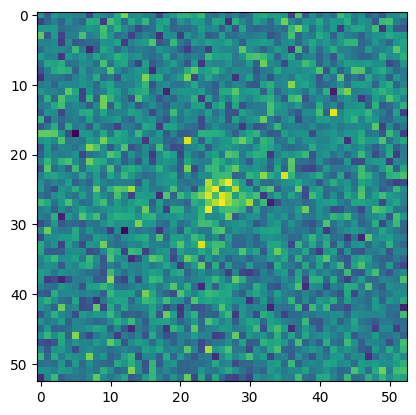

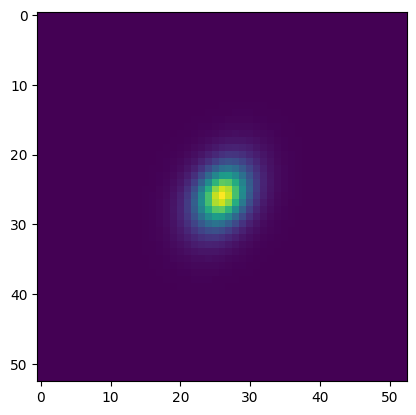

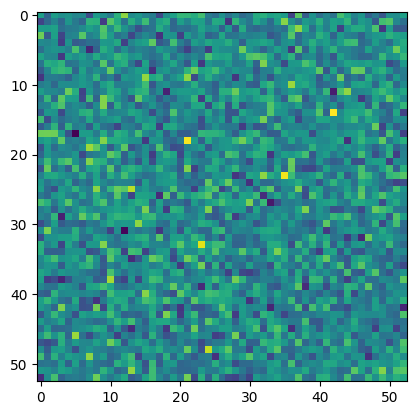

In [ ]:
plt.figure()
plt.imshow(im[0, 0])
plt.figure()
plt.imshow(nim[0,0])
plt.figure()
plt.imshow(im[0,0] - nim[0, 0])

In [ ]:
with torch.no_grad():
    recon = ae.forward(im, background[:10])

In [ ]:
from bliss.datasets.galsim_blends import _render_one_galaxy
gparams = galaxy_params[mask][indices][6]
im_example = _render_one_galaxy(gparams, psf, 53)

In [ ]:
gparams

tensor([2.2951e-19, 1.3725e-17, 0.0000e+00, 2.0197e-01, 9.4781e-01, 1.9863e-01,
        4.3301e-01, 2.2312e+02, 2.2312e+02, 2.4606e+01, 1.0268e+05])

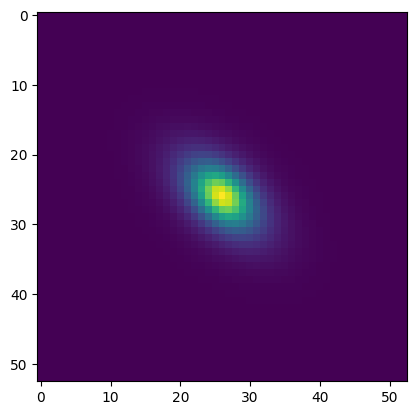

In [ ]:
plt.imshow(im_example[0])

<Figure size 640x480 with 0 Axes>

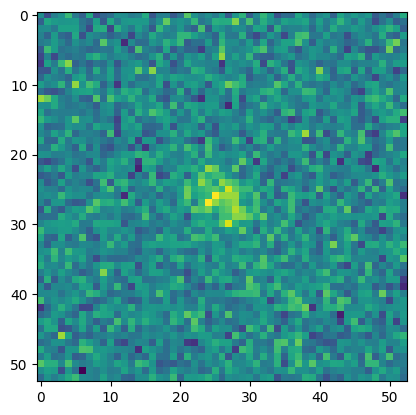

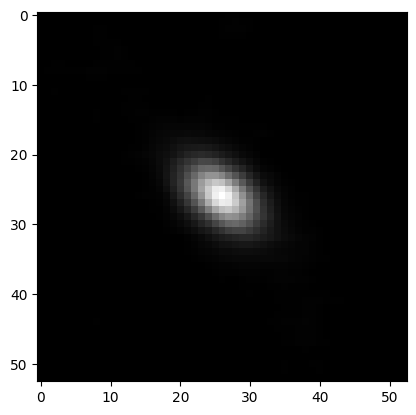

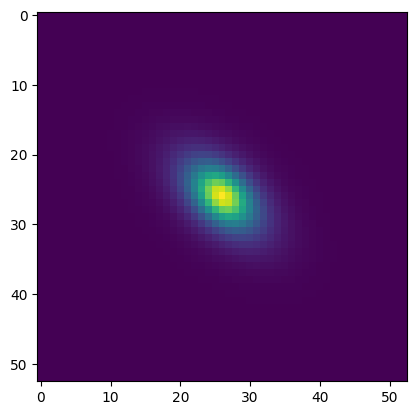

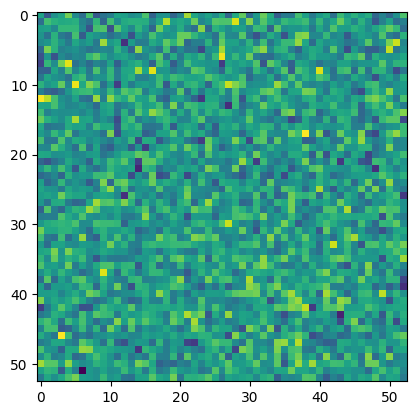

<Figure size 640x480 with 0 Axes>

In [ ]:
idx =6
plt.figure()
plt.imshow(im[idx, 0])
plt.figure()
plt.imshow(recon[idx,0].numpy(), cmap='gray')
plt.figure()
plt.imshow(nim[idx,0])
plt.figure()
plt.imshow(im[idx,0] - recon[idx,0].numpy())
plt.figure()


In [ ]:
beta1[6] / torch.pi * 180

tensor(43.1237)

In [ ]:
for ii in range(10):
    f1 = nim[ii,0].sum()
    f2 = (im[ii,0] - background[0,0]).sum()
    f3 = (recon[ii,0] - background[0,0]).sum()
    print(f1, f2, f3)

tensor(55501.4219) tensor(25841.7344) tensor(59928.6719)
tensor(50620.9258) tensor(90406.1562) tensor(61439.6875)
tensor(40849.6875) tensor(76536.7188) tensor(55461.9531)
tensor(39951.1836) tensor(83057.9375) tensor(57346.2031)
tensor(64083.2773) tensor(66487.0781) tensor(68773.5625)
tensor(51384.6133) tensor(60950.7500) tensor(51826.2812)
tensor(102153.6172) tensor(110454.5312) tensor(94679.0312)
tensor(37628.8672) tensor(29777.1875) tensor(42028.5156)
tensor(50711.0977) tensor(83126.2344) tensor(65632.1094)
tensor(64204.1484) tensor(52356.4688) tensor(72620.7812)


In [ ]:
iidx = 3
_a = a1[iidx] / 0.2
_b = b1[iidx] / 0.2
_beta = beta1[iidx]
data = im[idx, 0] - background[0,0]
sep.sum_ellipse(data.numpy(), np.array([26]), np.array([26]), a=_a, b=_b, theta=0, var=background[0,0].numpy()) # err = sigma

(array([75853.33875]), array([7296.40037707]), array([0], dtype=int16))

In [ ]:
_beta * 180 / np.pi

tensor(46.2046)

In [ ]:
data = nim[idx, 0]
sep.sum_circle(data.numpy(), np.array([26]), np.array([26]), r=5, var=0)

(array([28441.68198151]), array([0.]), array([0], dtype=int16))

In [ ]:
data = recon[idx, 0] - background[0,0]
sep.sum_circle(data.numpy(), np.array([26]), np.array([26]), r=5, var=0)

(array([29109.35375]), array([0.]), array([0], dtype=int16))

In [ ]:
800 / 2266.04283113

0.3530383402334309

In [ ]:
np.sqrt(25 * background[0,0])

tensor([[2142.7402, 2142.7402, 2142.7402,  ..., 2142.7402, 2142.7402,
         2142.7402],
        [2142.7402, 2142.7402, 2142.7402,  ..., 2142.7402, 2142.7402,
         2142.7402],
        [2142.7402, 2142.7402, 2142.7402,  ..., 2142.7402, 2142.7402,
         2142.7402],
        ...,
        [2142.7402, 2142.7402, 2142.7402,  ..., 2142.7402, 2142.7402,
         2142.7402],
        [2142.7402, 2142.7402, 2142.7402,  ..., 2142.7402, 2142.7402,
         2142.7402],
        [2142.7402, 2142.7402, 2142.7402,  ..., 2142.7402, 2142.7402,
         2142.7402]])

In [ ]:
nim[0, 0, 26, 26]

tensor(1407.2015)

In [ ]:
data.numpy()

array([[   3.828125,  -17.      , -103.0625  , ..., -101.828125,
        -492.20312 , -423.10938 ],
       [-248.84375 ,  189.03125 , -182.32812 , ...,    2.359375,
        -205.0625  ,   45.546875],
       [-133.90625 , -484.76562 ,  353.51562 , ...,  236.625   ,
         287.57812 , -742.65625 ],
       ...,
       [ 645.0625  ,  635.28125 , -614.7969  , ...,  304.92188 ,
         -73.625   , -152.35938 ],
       [ 220.1875  ,  107.046875,  600.3906  , ..., -139.73438 ,
        -767.6094  ,  591.71875 ],
       [-468.5     ,  623.8594  ,  135.26562 , ...,  583.1094  ,
        -112.03125 , -251.5625  ]], dtype=float32)

In [ ]:
f1, f3, f2aa

(tensor(50456.3320), tensor(52304.6250), tensor(55846.9531))